

#### Parameters
$$\text{There is a 5x5 grid  } M_{nm} \text{  and a set of agents  }a\epsilon A, \text{  of cardinality 4, with the grid having one "pick up" point at  }M_{ij} \text{where}\\ \text{an agent picks up a package,}\text{ and one "dropoff" point at  }M_{kl} \text{  where an agent drops off the package}.$$ 
(it is assumed that the supply and demand of the packages are infinite)

#### Objective
##### Final performance: after training, your agents must be able to perform a single delivery from A/B to A/B in at least 75% of all scenarios within at most 25 steps collision-free.

#### Budgets
Step budget: 1,500,000 (Maximum number of agent steps allowed during training)
Collision budget: 4,000 (Max num of head-on collisions allowed during training. Collisions at A and B allowed)
Walltime budget: 10 minutes (Maximum runtime allowed for training)

#### Constraints
$$\text{1. Actions of the agents are only "North", "South", "East" and "West". The pickups and dropoffs are automatic upon reaching A/B}$$
$$\text{2. Each agent must start at either the pickup or dropoff points, not both.}$$
$$\text{3. The agents cannot be in a "waiting" state (cannot sit still in one cell)}$$
$$\text{4. An agent that is en route to  }M_{ij} \text{ and another en route to  } M_{kl} \text{ can never be on the same cell}$$
$$\text{5. The agents can only observe the 8 adjacent cells to them.}$$
$$\text{6. Both pickup and dropoff points at  }M_{ab} \text{  and  }M_{cd} \text{  can never be occupied}$$

$$\text{7. for any cell  } M_{ij} \  !=  \ M_{ab}, M_{ab} \text{  and agent  } a_1 \text{  is at  } M_{ij}, \\ \text{ that location is said to be OCCUPIED iff there is another "nearby"  } a_2 \text{  who's route is opposite to it.}$$
$$\text{8. All agents normally have to perform their actions sequentially in a random order.}$$

### All Possible Scenarios Must Be Tested 
(ex: all agents at A, all at B, randomized, etc)
--- -

1. You may augment the observation space for all agents with the occupancy state of 
all cells or chosen cells in the agent’s immediate 8-neighbourhood (unoccupied, occupied)

2. As per previous entry, only cells that contain  an agent going in the opposite 
direction (as defined above) will be marked as occupied.

### Rewards
The reward function maps state space and action space into the real numbers. Whatever is outside the agent's state and the action it chooses is not allowed. For example (but not limited to): agent's direction, distance to A and/or B and/or other agents, cardinal points (NWSE of A and/or B and/or other agents), hard-coded rules for collision avoidance, etc.

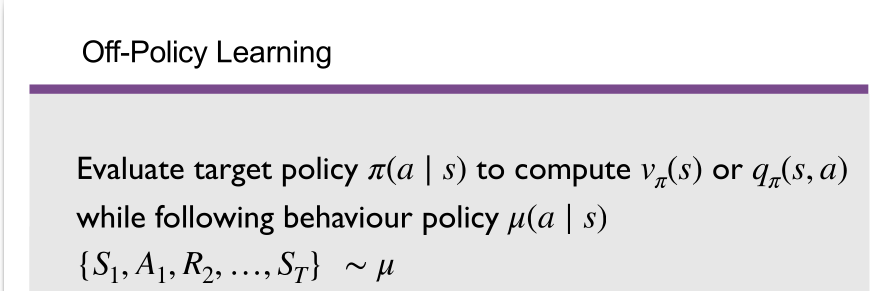

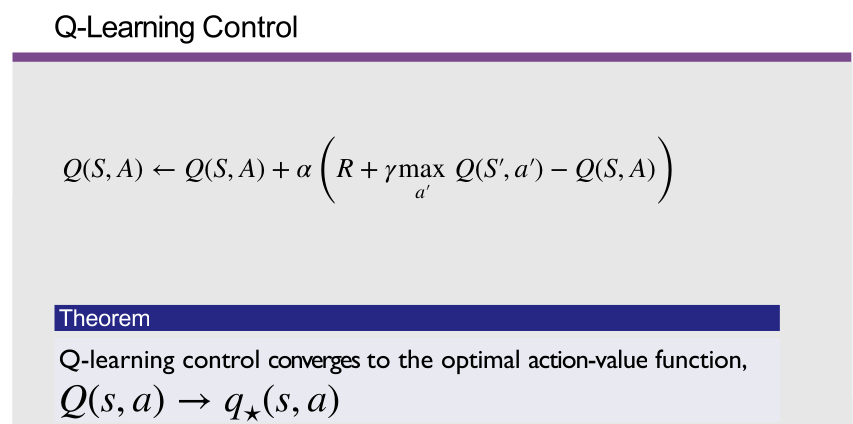

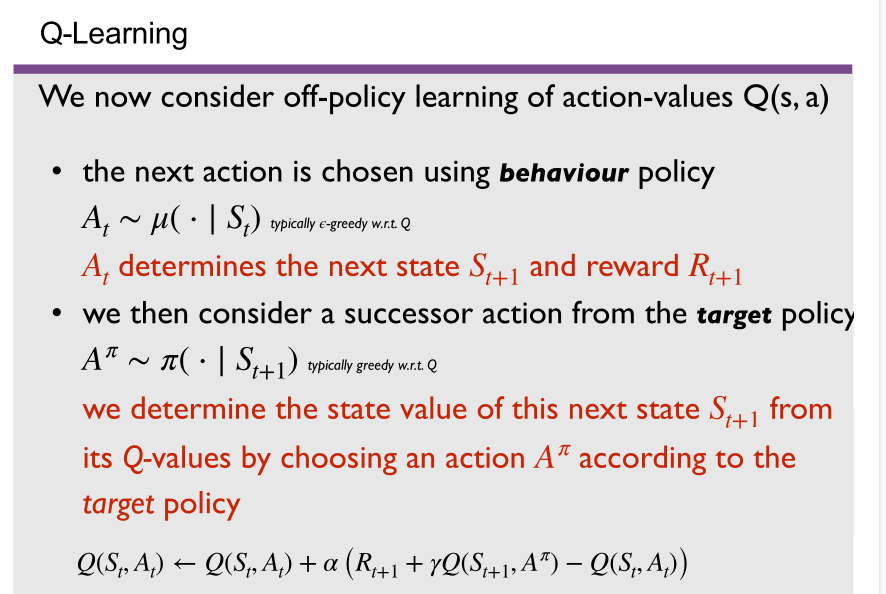

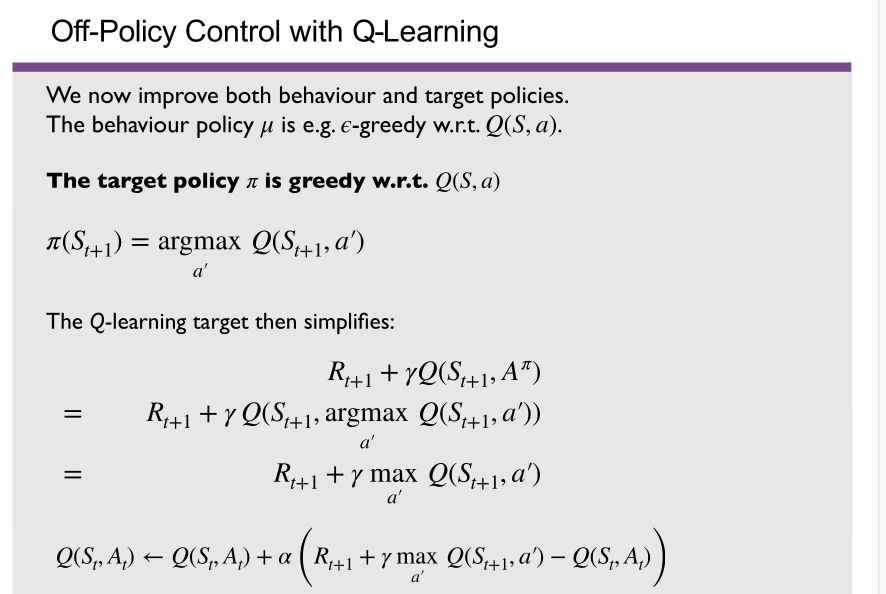

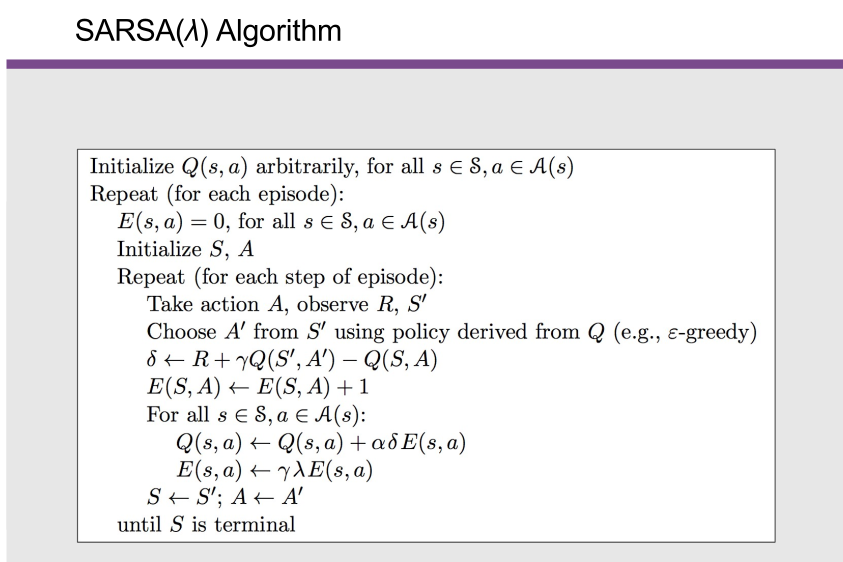

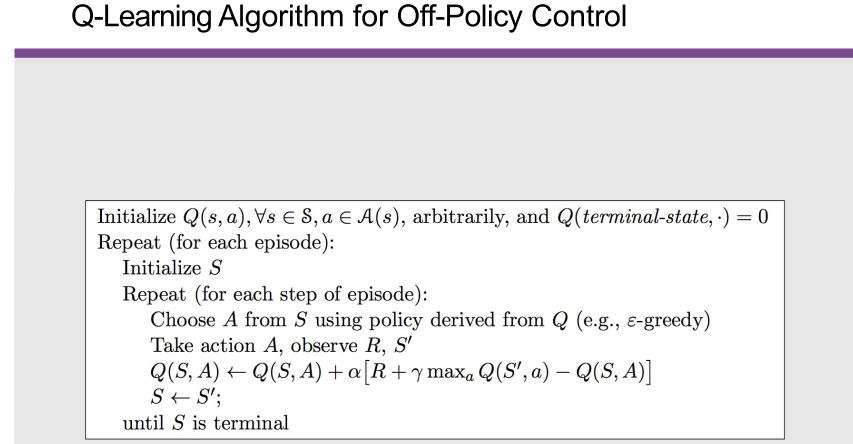

In [1]:
from IPython.display import display
from IPython.display import Image


display(Image(filename="/home/emeka/.Monash/s125/mas/a1/offp_le.png"))
display(Image(filename="/home/emeka/.Monash/s125/mas/a1/ql_control.png"))
display(Image(filename="/home/emeka/.Monash/s125/mas/a1/ql_steps.png"))
display(Image(filename="/home/emeka/.Monash/s125/mas/a1/policy_update.png"))
display(Image(filename="/home/emeka/.Monash/s125/mas/a1/sarsala_algo.png"))
Image(filename="/home/emeka/.Monash/s125/mas/a1/ql_algo.png")




In [108]:
import numpy as np
import random as RD
import scipy
from IPython.display import display

""" 
TODO: account for infinitely large grid
TODO: figure out what this means: "so the matrix would expand from 5x5 to 2x5x5."
TODO: randomize loctions/absorbing states each episode
"""
# Define the grid world environment

class GridWorld:   
    def __init__(self):     
        self.grid = [[0,1,2,3,4],
                 [5,6,7,8,9],
                 [10,11,12,13,14],
                 [15,16,17,18,19],
                 [20,21,22,23,24]
                 ]
        self.grid_length = len(self.grid)*len(self.grid)
        self.rewards = []
        self.reward = 0
        self.absorbing_states = [(0,0), (4,4)]
        self.step_budget = 25
    

    def total_reward(self):
        return sum(self.rewards)        
        
    def init_grid(self):
        print(self.grid[1][0])
        return np.array(self.grid)
    
    def assign_pickup_dropoff(self):
        pickup = RD.randint(0,24)
        dropoff = RD.randint(0,24)
        while pickup == dropoff:
            dropoff = RD.randint(0,24)
        return pickup, dropoff
    
    '''transition probabilities'''
    '''
    def set_transition_pr(self):
         # Generate random matrix between 0.1 and 0.9
        transition_matrix = np.random.uniform(0.1, 0.9, size=(5, 5))
        #make sure absorbing state at pickup/dropoff
        transition_matrix[4][4] = 1
        transition_matrix[0][0] = 1
        # Normalize each row to sum to 1
        transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
        # rounded    
        return np.round(transition_matrix, 1)
    '''
    def set_transition_pr(self):
        
        # Generate random matrix between 0.1 and 0.9
        transition_matrix = np.random.uniform(0.1, 0.9, size=(5, 5))
        
        # Convert to 2D coordinates for easier handling
        for i in range(5):
            for j in range(5):
                if (i, j) in self.absorbing_states:
                    # Create absorbing state - all probabilities 0 except self-transition
                    transition_matrix[i, j] = 0
                    transition_matrix[i, i] = 1.0  # Self-transition probability 1.0
                else:
                    # Normal non-absorbing state
                    pass
        
        # Normalize each row to sum to 1 (except absorbing states)
        for i in range(5):
            if (i, i) not in self.absorbing_states:  # Only normalize non-absorbing rows
                row_sum = transition_matrix[i].sum()
                if row_sum > 0:
                    transition_matrix[i] /= row_sum
        
        # Round to 1 decimal place
        transition_matrix = np.round(transition_matrix, 1)
        
        # Ensure absorbing states are exactly 1.0 on diagonal
        for state in self.absorbing_states:
            i, j = state
            
            transition_matrix[i, j] = 1.0
            transition_matrix[i, :] = 0.0  # Zero out other transitions
            transition_matrix[i, i] = 1.0
        
        return transition_matrix
    
    def grid_tm_map(self):
        tm = self.set_transition_pr()  # Get your transition matrix
        gt = {}  # Initialize the dictionary

        for i in range(len(self.grid)):  # Loop through row indices
            for j in range(len(self.grid[i])):  # Loop through column indices
                grid_value = self.grid[i][j]  # The actual value in the grid (e.g., 0-24)
                transition_probs = tm[i][j]  # Corresponding transition probabilities

                # Map grid value to its transition probabilities
                gt[grid_value] = transition_probs

        return gt
   
        
        
prox = GridWorld()
prox.init_grid()
prox.assign_pickup_dropoff()
display("transition probabilities", prox.set_transition_pr())
display("grid length", prox.grid_length)
print("mapping", prox.grid_tm_map()[0], prox.grid_tm_map()[24])
for i in prox.grid_tm_map():
    print(prox.grid_tm_map()[i])

    

5


'transition probabilities'

array([[1. , 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0.2, 0.1, 0.3],
       [0.3, 0.2, 0.2, 0.1, 0.2],
       [0.2, 0.1, 0.3, 0.3, 0.1],
       [0. , 0. , 0. , 0. , 1. ]])

'grid length'

25

mapping 1.0 1.0
1.0
0.0
0.0
0.0
0.0
0.2
0.3
0.2
0.3
0.2
0.3
0.0
0.1
0.2
0.1
0.1
0.2
0.1
0.2
0.2
0.0
0.0
0.0
0.0
1.0


In [ ]:
class Learn:
    def __init__(self, agent, gridworld):
        self.current_state = 0
        policy = None
        self.agent = agent
        self.gridworld = gridworld
        self.alpha = 0.33
        self.gamma = 0.98
        self.episodes = 2
        
        
    '''
    def q_learn(self):
        qtable = (())
        for epoch in range(self.episodes):
            self.agent = np.random.randint(0, self.agent.step_budget)  
            while current_state != self.agent.goal_state:
                # --- Step 1: Compute action probabilities ---
                self.gridworld.transition_matrix()
                best_action = np.argmax(Q_table[current_state])
                m = self.agent.step_budget  # Total number of actions
            
    # TODO: set step penalty > 10 when agent walks into wall        
            
            
            
            while self.agent.current_state != self.agent.goal_state[0]:
                if np.random.rand() < exploration_prob:
                    action = np.random.randint(0, n_actions)  
                else:
                    action = np.argmax(Q_table[current_state])  

                next_state = (current_state + 1) % n_states

                reward = 1 if next_state == goal_state else 0

                Q_table[current_state, action] += learning_rate * \
                    (reward + discount_factor *
                     np.max(Q_table[next_state]) - Q_table[current_state, action])

                current_state = next_state
          '''      
       

        
                 
    def qloop(self):
        
                # 4. Q-update
                Q_table[current_state, action] += learning_rate * (
                    reward + discount_factor * np.max(Q_table[next_state]) - Q_table[current_state, action]
                )
                current_state = next_state
                # Inside the Q-learning loop
                if next_state == current_state:  # Agent didn't move (hit wall or chose "stay")
                    reward = -10  # Large penalty for staying
                    consecutive_penalty += -5  # Additional penalty per step stuck
                else:
                    consecutive_penalty = 0  # Reset if moving
                    reward = -1  # Default step penalty
                total_reward = reward + consecutive_penalty
    
                
                
l = Learn(agent=Agent(),gridworld=GridWorld())
display("step budget from agent class", l.agent.step_budget)
display("absorbing states from grid class", l.gridworld.absorbing_states)

'step budget from agent class'

25

'absorbing states from grid class'

[(0, 0), (4, 4)]

In [ ]:
# Define the learning parameters
learning_rate = 0.3
discount_factor = 0.98
num_episodes = 50000
max_steps = 25 
epsilon_initial = 1.0
epsilon_final = 0.1
epsilon_decay = 0.99995 
# Define the grid world dimensions
grid_rows = 5
grid_cols = 5
# Define the number of actions (up, down, left, right)
num_actions = 4
'''Note: For now, pickup A is at [0,0] and B is at [4,4]'''
class QTableAgent:
    def __init__(self, gridworld=GridWorld):
        '''1. Initial Q-Tbale'''
        # zeros(num of states, num of actions)
        self.q_table = np.zeros((25, 4))  # Add one extra dimension for reached A or not
        self.actions = ((1,1), (2,2), (1,2), (2,1))
        self.step_budget = 25
        '''2. Grid'''   
        self.grid = [[0,1,2,3,4],
                [5,6,7,8,9],
                [10,11,12,13,14],
                [15,16,17,18,19],
                [20,21,22,23,24]
                ]
        self.goal_state = self.grid[4][4]
        self.start_state = self.grid[0][0]
        self.gridworld = gridworld
    
   
    
    '''4. Define the policy'''
    def policy(self):
        
        
        
     '''5 Initialize Agent'''
    def init_agent(self):
        # start at either A or B
        self.pos = RD.randint(0,1)
        if self.pos == 0:
            dy = 0
            dx = 0
            init_poisition = (dy,dx)
        elif self.pos == 1:
            dy = 4
            dx = 4
            init_poisition = (dy,dx)
        return init_poisition
    
    '''4.1 Have Agent transition from one state to another'''
    def transit_state(self, state, epsilon):
        for epoch in range(self.agent.step_budget):
            #current_state = np.random.randint(0, self.agent.step_budget)
            
            while self.current_state != self.agent.goal_state:
                # 1. Choose action (ε-greedy)
                best = np.argmax(self.gridworld.grid_tm_map())
                if np.random.rand() < {}:
                    # choose random action
                    action = np.random.randint(0, 4)
                else:
                    # get current state q-value
                    action = np.argmax({})
                # 2. Get next state (may be invalid)
                next_state = self.get_next_state(current_state, action)
                # 3. Assign reward
                if next_state == current_state:  # Hit wall
                    reward = -0.2
                elif next_state == self.goal_state:
                    reward = +1
                else:
                    reward = -0.1
        
        # Choose an action based on the epsilon-greedy policy
        if np.random.uniform(0, 1) < epsilon:
            # choose within 1 cell length
            
            action = np.random.choice(GridWorld.grid_tm_map())
        else:
            action = np.argmax(self.q_table[state])

        return action

    '''1.1 Update the Q-Table'''
    def update_q_table(self, Q, state, action_idx, reward, next_state, alpha, gamma):
        Q = self.q_table
        
        
        """
            Updates Q-table using the Q-learning update rule.
    
            Parameters:
            - Q: 2D numpy array of shape [num_states x num_actions]
            - state: current state (int)
            - action_idx: index of action taken (int)
            - reward: observed reward (float)
            - next_state: state transitioned to (int)
            - alpha: learning rate (float)
            - gamma: discount factor (float)
    
            only ONE entry is updated each time, which is Q(s,a)
    
            #max_q_next = np.max(Q[next_state])
            #td_target = reward + gamma * max_q_next
            #td_error = td_target - Q[state, action_idx]
            #Q[state, action_idx] += alpha * td_error
        """

prox = QTableAgent()
print(prox.q_table)
grox = GridWorld()
print(grox.grid_tm_map())
for i in prox.grid_tm_map():
    print(i)

    

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
{0: np.float64(1.0), 1: np.float64(0.0), 2: np.float64(0.0), 3: np.float64(0.0), 4: np.float64(0.0), 5: np.float64(0.2), 6: np.float64(0.2), 7: np.float64(0.3), 8: np.float64(0.2), 9: np.float64(0.2), 10: np.float64(0.2), 11: np.float64(0.1), 12: np.float64(0.3), 13: np.float64(0.2), 14: np.float64(0.2), 15: np.float64(0.2), 16: np.float64(0.1), 17: np.float64(0.2), 18: np.float64(0.2), 19: np.float64(0.2), 20: np.float64(0.0), 21: np.float64(0.0), 22: np.float64(0.0), 23: np.float64(0.0), 24: np.float64(1.0)}


AttributeError: 'QTableAgent' object has no attribute 'absorbing_states'

In [ ]:
def run_episode():
    num_episodes = 0
    for episode in range(num_episodes+1):   
        if (episode == 5000):
            print(episode, "episodes")
            return 1
        elif get_agent_position == goal_position:
            reached_A = True
            return 1
        else:
            max_steps = 25
            reset()
            number_of_steps = 1
            reward_per_episode =  1
            take_action = choose_action()
            while number_of_steps<= max_steps and (agent_position != nest_location or reached_A != True):  
                # Continue until reaching location B or too many steps   
                state = get_state()
                action = choose_action(state)
                reward = take_action(action)
                reward_per_episode += reward
                done = check_done()
                number_of_steps += 1
            reward_total.append(reward_per_episode)

# Main()

In [ ]:

solution = Learn(agent=Agent, gridworld=GridWorld)


TypeError: Learn.__init__() missing 1 required positional argument: 'state'